In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [2]:
def fillhole(input_image):
    T,I = cv2.threshold(input_image,160,255,cv2.THRESH_BINARY)
    I = cv2.medianBlur(I, 3)
    im_flood_fill = I.copy()
    
    h, w = input_image.shape[:2]
    mask = np.zeros((h + 2, w + 2), np.uint8)
    im_flood_fill = im_flood_fill.astype("uint8")
    
    cv2.floodFill(im_flood_fill, mask, (0, 0), 255)
    im_flood_fill_inv = cv2.bitwise_not(im_flood_fill)
    img_out = input_image | im_flood_fill_inv
    
    return img_out


def Cluster(I):
    I_detected = np.copy(I)
    contours, _ = cv2.findContours(I_detected, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    num = 0
    grain_coord = []
    area = []
    perimeter = []
    for c in contours:        
        A = cv2.contourArea(c)
        if A < 300 or A > 1800: continue
        print(num, A)
        num += 1
        
        minAreaRect = cv2.minAreaRect(c)
        rectCnt = np.int64(cv2.boxPoints(minAreaRect))
        cv2.drawContours(I_detected, [rectCnt], 0, (0,0,0), 2)
        P = cv2.arcLength(c, closed=True)
        
        grain_coord.append(rectCnt)
        area.append(A)
        perimeter.append(P)
            
    return I_detected, num, np.array(grain_coord), area, perimeter


def calculateDistance(x1,y1,x2,y2):  
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)  
    return dist

inspected grains =  0


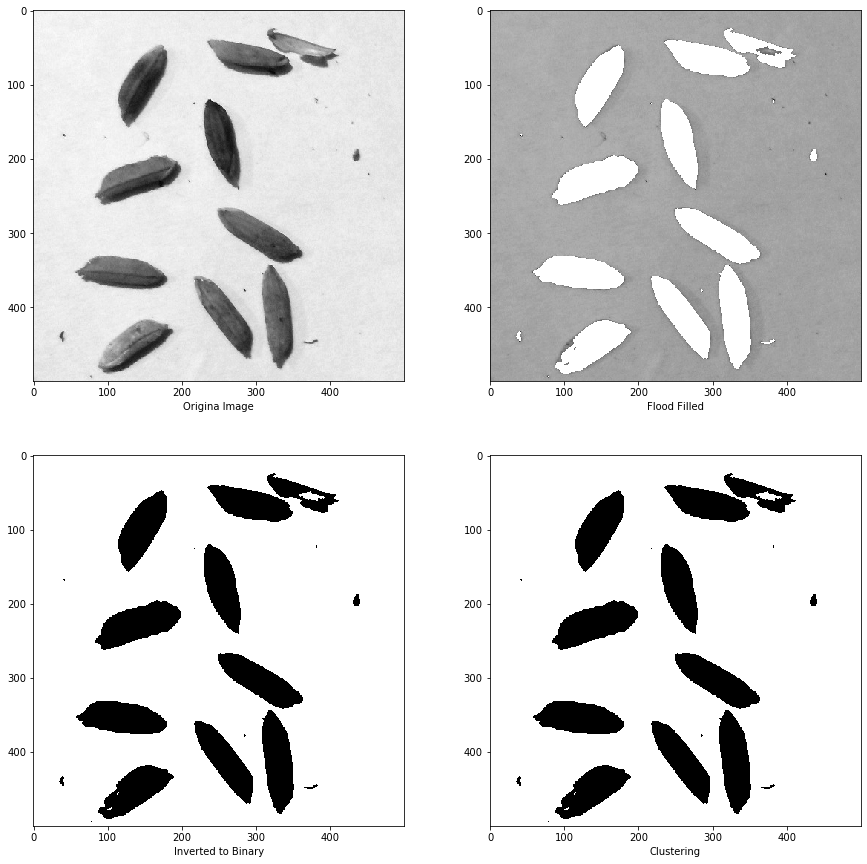

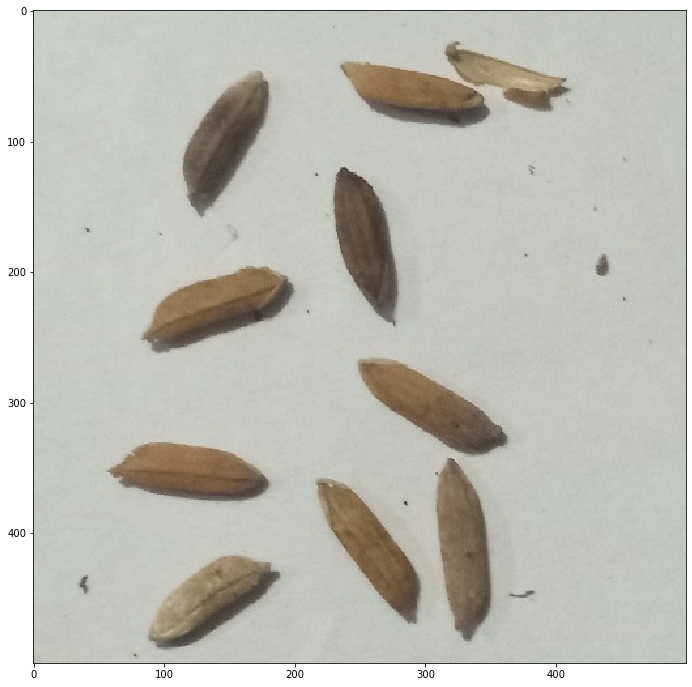

In [8]:
path = 'dataset/compressed/bad_90%/2.jpg'

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)

img = cv2.imread(path, 0)
fig.add_subplot(2,2,1)
plt.imshow(img, cmap='gray')
plt.xlabel('Origina Image')


new_img = fillhole(img)
fig.add_subplot(2,2,2)
plt.imshow(new_img, cmap='gray')
plt.xlabel('Flood Filled')


T,I = cv2.threshold(new_img,250,255,cv2.THRESH_BINARY_INV)
fig.add_subplot(2,2,3)
plt.imshow(I, cmap='gray')
plt.xlabel('Inverted to Binary')


I_detected, count, grain_coord, area, perimeter = Cluster(I)
fig.add_subplot(2,2,4)
plt.imshow(I_detected, cmap='gray')
plt.xlabel('Clustering')

print('inspected grains = ', count)

plt.show()


ha = []
wa = []
Aa = []
Pa = []
A_Pa = []
A_APa = []
A_WHa = []
diaa = []

for i in range(count):
    a = calculateDistance(grain_coord[i,0,0], grain_coord[i,0,1], grain_coord[i,1,0], grain_coord[i,1,1])
    b = calculateDistance(grain_coord[i,1,0], grain_coord[i,1,1], grain_coord[i,2,0], grain_coord[i,2,1])
    h = max(a, b)
    w = min(a, b)
    
    ha.append(h)
    wa.append(w)
    Aa.append(area[i])
    Pa.append(perimeter[i])
    A_Pa.append(area[i] / perimeter[i])
    A_APa.append(area[i] / (area[i] + perimeter[i]))
    A_WHa.append(area[i] / (w*h))
    diaa.append(((4*area[i])/np.pi)**(0.5))
    
    
    
    
I = cv2.imread(path)
for i in range(count):
    cv2.drawContours(I, [grain_coord[i]], 0, (0,0,0), 1)
    cv2.putText(I,str(i),(grain_coord[i][0][0],grain_coord[i][0][1]),0,0.5,(0,0,0), 2)

plt.figure(figsize=(12,12))
plt.imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
label = np.zeros(count, dtype=np.int)
label[[1, 4]] = 1

data = {'Height': ha,
        'Width': wa,
        'Area' : Aa,
        'Perimeter' : Pa,
        'A/P' : A_Pa,
        'A/(A+P)' : A_APa,
        'A/(W*H)' : A_WHa,
        'Diameter' : diaa,
        'Label' : label
        }

temp = pd.DataFrame (data, columns = ['Height', 'Width', 'Area', 'Perimeter', 'A/P', 'A/(A+P)', 'A/(W*H)', 'Diameter', 'Label'])

temp

,Height,Width,Area,Perimeter,A/P,A/(A+P),A/(W*H),Diameter,Label
0,79.630396,26.305893,1531.5,185.781744,8.243544,0.891816,0.731114,44.158423,0
1,83.000000,27.000000,1601.5,190.124890,8.423411,0.893881,0.714636,45.156319,1
2,78.000000,29.000000,1758.0,192.367531,9.138756,0.901369,0.777188,47.311258,0
3,73.000000,28.000000,1493.5,174.953317,8.536563,0.895140,0.730675,43.607147,0
4,37.013511,25.612497,690.5,112.124890,6.158312,0.860302,0.728369,29.650833,1
5,71.568149,32.249031,1753.0,179.539104,9.763890,0.907097,0.759531,47.243930,0
6,92.195445,25.019992,1654.0,205.539104,8.047131,0.889468,0.717033,45.890502,0
7,29.068884,16.124515,341.5,75.012193,4.552593,0.819904,0.728577,20.852129,0


In [5]:
# temp = temp.drop([5])
# temp

# df = pd.DataFrame()
# df

df = df.append(temp, ignore_index = True) 

df

NameError: name 'df' is not defined